# Regression (Linear and Logistic) and LDA using TensorFlow
BITS F464 Assigment 3

### Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
# df=pd.read_csv('./coa_data.csv')
df=pd.read_csv('/content/Admission_Predict_A3.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [ ]:
df.shape

(500, 9)

In [ ]:
df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [ ]:
df.isnull().sum()

,0
Serial No.,0
GRE Score,0
TOEFL Score,0
University Rating,0
SOP,0
LOR,0
CGPA,0
Research,0
Chance of Admit,0


In [ ]:
df.isna().sum()

,0
Serial No.,0
GRE Score,0
TOEFL Score,0
University Rating,0
SOP,0
LOR,0
CGPA,0
Research,0
Chance of Admit,0


In [ ]:
df.nunique()

,0
Serial No.,500
GRE Score,49
TOEFL Score,29
University Rating,5
SOP,9
LOR,9
CGPA,184
Research,2
Chance of Admit,61


Since serial no is unique to each row, it won't contribute anything to the model's learning.
Thus, we drop it.

In [ ]:
df.drop(['Serial No.'], axis=1, inplace=True)

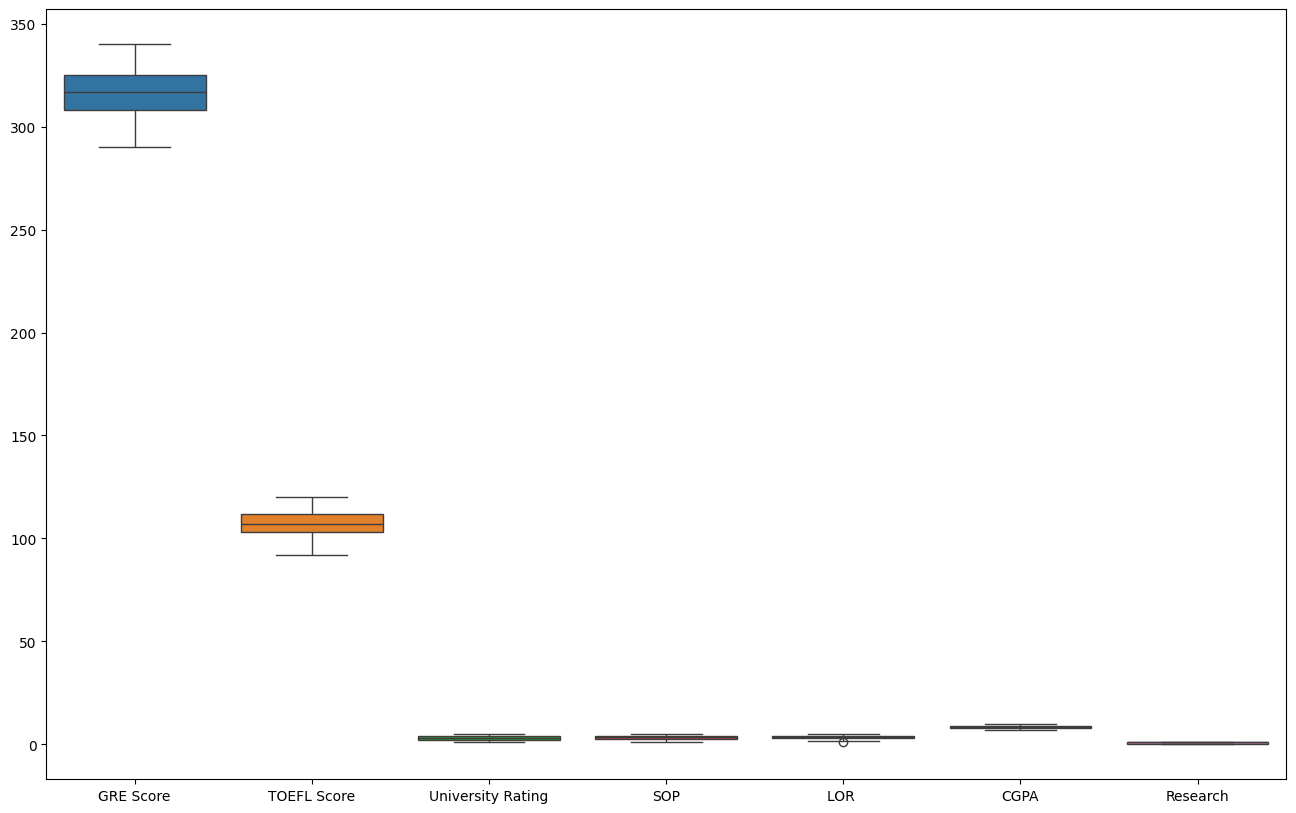

Number of outliers per attribute: 
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  1
CGPA                 0
Research             0
dtype: int64


In [ ]:
def outlier_handling(df,target):
    df_new = df.copy()
    df_new.drop([target], axis=1, inplace=True)
    plt.figure(figsize=(16, 10))
    sns.boxplot(data=df_new)
    plt.show()
    Q1 = df_new.quantile(0.25)
    Q3 = df_new.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df_new < (Q1 - 1.5 * IQR)) | (df_new > (Q3 + 1.5 * IQR))
    print("Number of outliers per attribute: \n", outliers.sum(), sep="")
    df = df[~outliers.any(axis=1)]

outlier_handling(df,"Chance of Admit ")

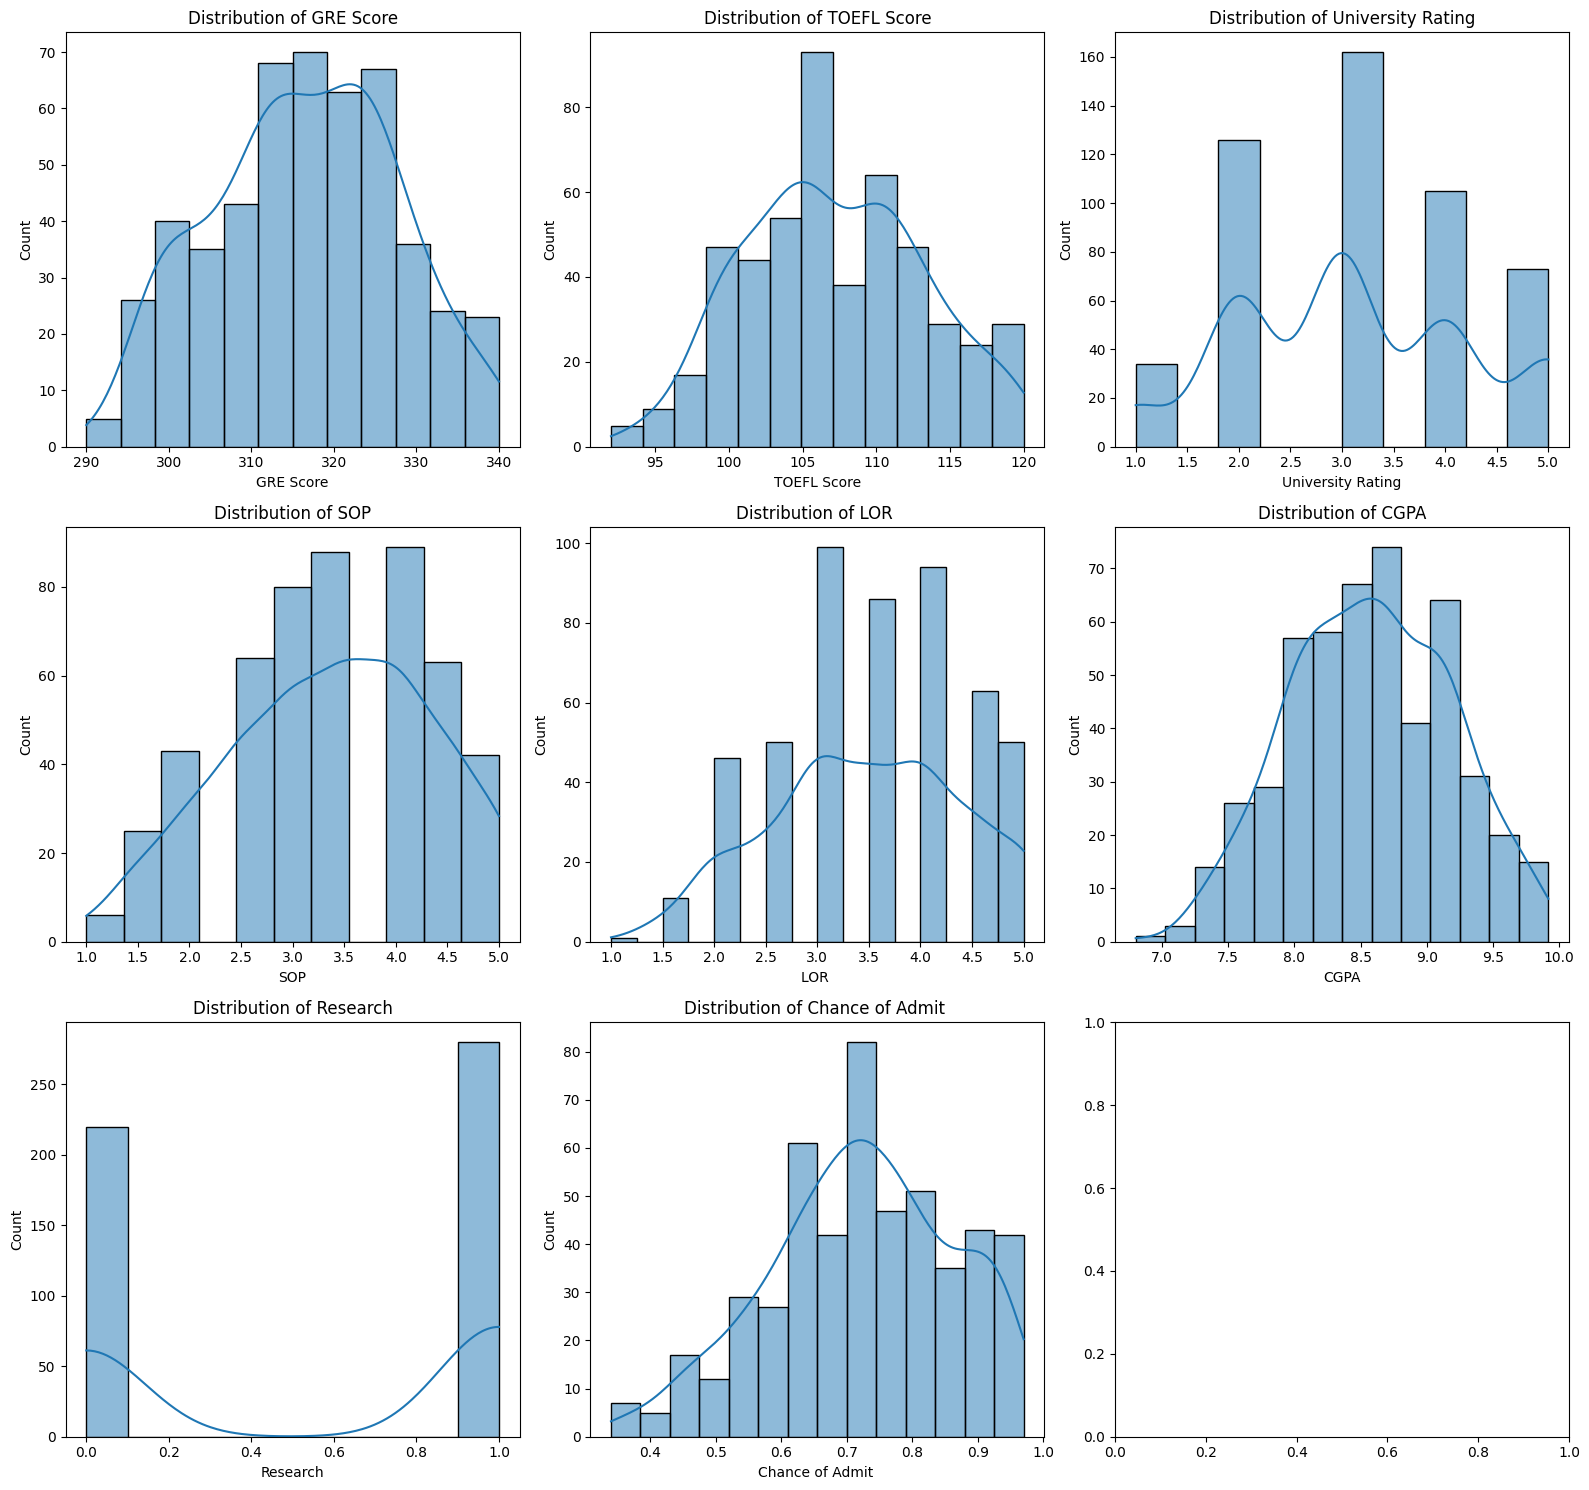

In [ ]:
def visualize_numerical(df):
    num_cols = df.select_dtypes(include=['number']).columns
    num_plots = len(num_cols)
    num_rows = (num_plots // 3) + (num_plots % 3 > 0)
    fig, ax = plt.subplots(num_rows, 3, figsize=(16, 5*num_rows))
    for i, feature in enumerate(num_cols):
        row = i // 3
        col = i % 3
        sns.histplot(data=df, x=feature, ax=ax[row, col], kde=True)
        ax[row, col].set_title(f'Distribution of {feature}')
    plt.tight_layout()

visualize_numerical(df)

- We don't have many outlier, thus we won't use RobustScaler.
- Since no feature dominates others due to its range, we won't use MinMaxScaler.
- Since most features are normally distributed, we'll use StandardScaler.

### Data Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

def scaler(df, numerical_features, scaler):
    scaled_df = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)
    return scaled_df

y=df['Chance of Admit ']
df.drop(['Chance of Admit '], axis=1, inplace=True)
df=scaler(df,df.select_dtypes(include=[np.number]).columns,StandardScaler())
df['Chance of Admit ']=y

df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1.819238,1.778865,0.775582,1.137360,1.098944,1.776806,0.886405,0.92
1,0.667148,-0.031601,0.775582,0.632315,1.098944,0.485859,0.886405,0.76
2,-0.041830,-0.525364,-0.099793,-0.377773,0.017306,-0.954043,0.886405,0.72
3,0.489904,0.462163,-0.099793,0.127271,-1.064332,0.154847,0.886405,0.80
4,-0.219074,-0.689952,-0.975168,-1.387862,-0.523513,-0.606480,-1.128152,0.65


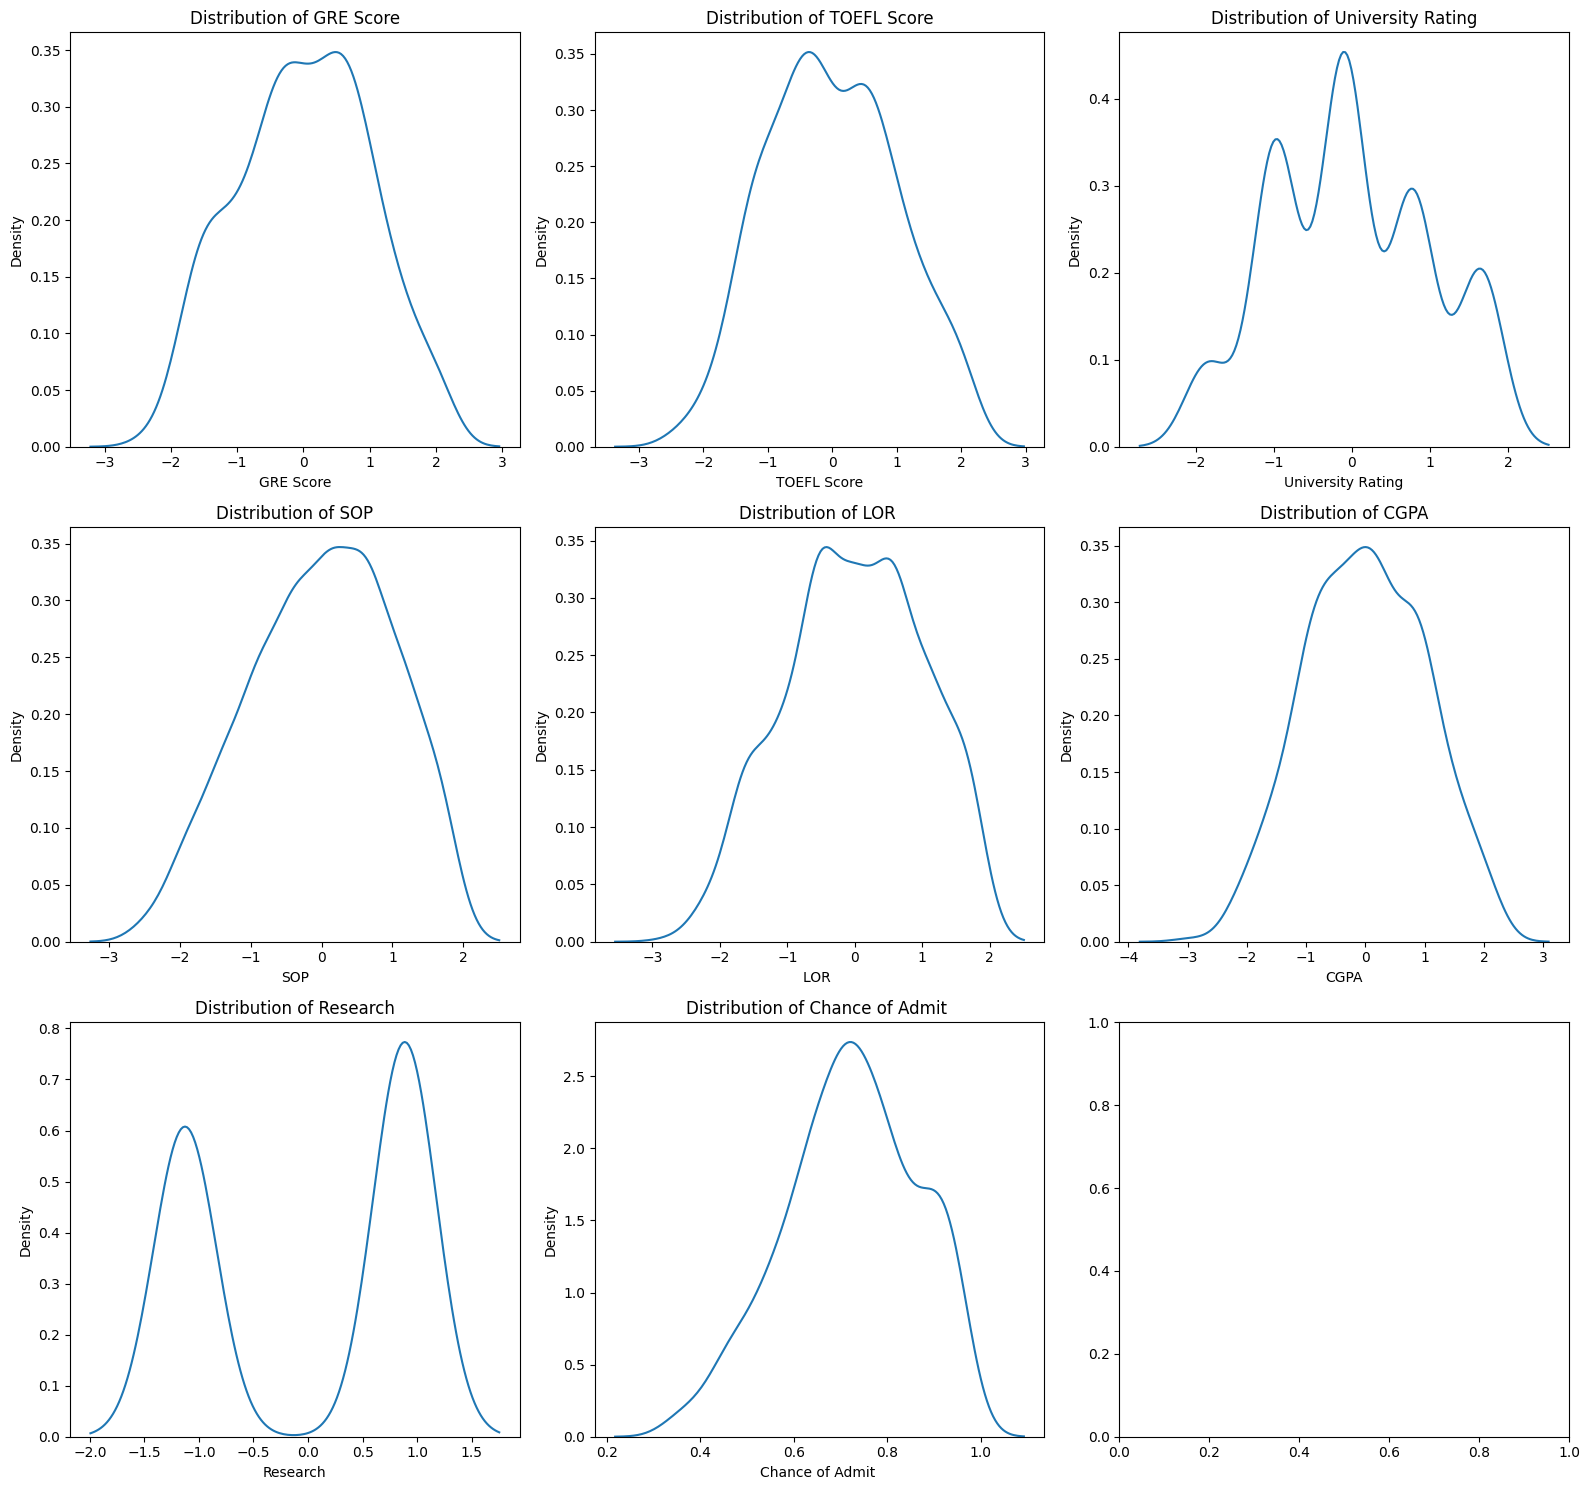

In [ ]:
def visualize_kde(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    num_plots = len(num_cols)
    num_rows = (num_plots // 3) + (num_plots % 3 > 0)
    fig, ax = plt.subplots(num_rows, 3, figsize=(16, 5*num_rows))
    for i, feature in enumerate(num_cols):
        row = i // 3
        col = i % 3
        sns.kdeplot(data=df, x=feature, ax=ax[row, col])
        ax[row, col].set_title(f'Distribution of {feature}')
    plt.tight_layout()

visualize_kde(df)

### Dimensionality Reduction with LDA

In [ ]:
df['Chance of Admit '].describe()

,Chance of Admit
count,500.00000
mean,0.72174
std,0.14114
min,0.34000
25%,0.63000
50%,0.72000
75%,0.82000
max,0.97000


In [ ]:
bins=[0,0.5,0.75,1]

labels=['Low','Medium','High']
df['Chance of Admit ']=pd.cut(df['Chance of Admit '],bins=bins,labels=labels)

df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1.819238,1.778865,0.775582,1.137360,1.098944,1.776806,0.886405,High
1,0.667148,-0.031601,0.775582,0.632315,1.098944,0.485859,0.886405,High
2,-0.041830,-0.525364,-0.099793,-0.377773,0.017306,-0.954043,0.886405,Medium
3,0.489904,0.462163,-0.099793,0.127271,-1.064332,0.154847,0.886405,High
4,-0.219074,-0.689952,-0.975168,-1.387862,-0.523513,-0.606480,-1.128152,Medium


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

X=df.drop(['Chance of Admit '],axis=1)
y=df['Chance of Admit ']

lda=LinearDiscriminantAnalysis()
X=lda.fit_transform(X,y)

df=pd.DataFrame(X,columns=['LDA1','LDA2'])
df['Chance of Admit ']=y

df.head()

,LDA1,LDA2,Chance of Admit
0,-3.088197,0.663746,High
1,-1.186912,-0.240582,High
2,0.867028,-0.926579,Medium
3,-0.332192,-1.136026,High
4,1.277001,1.267692,Medium


In [ ]:
df.shape

(500, 3)

In [ ]:
df_lda=df

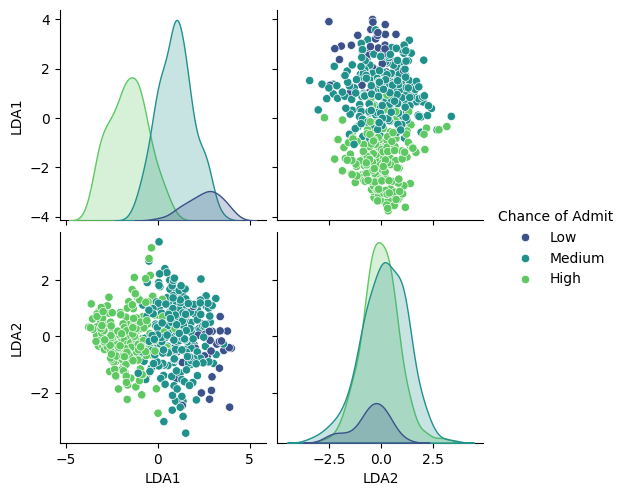

In [ ]:
sns.pairplot(data=df,hue='Chance of Admit ',palette='viridis')
plt.show()

#### LDA Insights

Justification for Number of Components
- Number of Classes: LDA retains min(n_classes - 1, n_features) components. Since we've retained 2 features, this implies that our dataset has 3 distinct classes (Low, Medium, High).

- Maximizing Class Separability: The goal of LDA is to project the data in a way that maximizes the distance between the means of different classes while minimizing the variance within each class. LDA has determined that with 2 features (k-1), we maximize the seperation.

Evaluation of Dimensionality Reduction
- Reduced Complexity: By reducing the number of features from the original dataset to 2, the complexity of the model is significantly reduced. This will lead to faster training times and simpler models.

- Visualization: With 2 components, it becomes easier to visualize the data and understand the class separability in a 2D plot.

- Overfitting Reduction: Reducing the number of features can help in mitigating overfitting, especially since the original dataset has a large number of features (8).



### Linear Regression on LDA Transformed Data

#### Implementation using Tensorflow

In [ ]:
df_copy=pd.read_csv('Admission_Predict_A3.csv')
y_original=df_copy['Chance of Admit ']
X_train, X_test, y_train, y_test = train_test_split(X, y_original, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

X_train_tensor = tf.constant(X_train, dtype=tf.float32)
y_train_tensor = tf.constant(y_train.values.reshape(-1, 1), dtype=tf.float32)
X_test_tensor = tf.constant(X_test, dtype=tf.float32)
y_test_tensor = tf.constant(y_test.values.reshape(-1, 1), dtype=tf.float32)

In [ ]:
num_features = X_train_tensor.shape[1]
W = tf.Variable(tf.random.normal([num_features, 1], dtype=tf.float32), name="weights")
b = tf.Variable(tf.random.normal([1], dtype=tf.float32), name="bias")


In [ ]:
def linear_regression(X):
    return tf.matmul(X, W) + b

def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


In [ ]:
optimizer = tf.optimizers.SGD(learning_rate=0.01)

epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        y_pred = linear_regression(X_train_tensor)

        loss = mean_squared_error(y_train_tensor, y_pred)

    gradients = tape.gradient(loss, [W, b])

    optimizer.apply_gradients(zip(gradients, [W, b]))

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}: Loss = {loss.numpy():.4f}")


Epoch 100: Loss = 0.0521
Epoch 200: Loss = 0.0044
Epoch 300: Loss = 0.0036
Epoch 400: Loss = 0.0036
Epoch 500: Loss = 0.0036
Epoch 600: Loss = 0.0036
Epoch 700: Loss = 0.0036
Epoch 800: Loss = 0.0036
Epoch 900: Loss = 0.0036
Epoch 1000: Loss = 0.0036


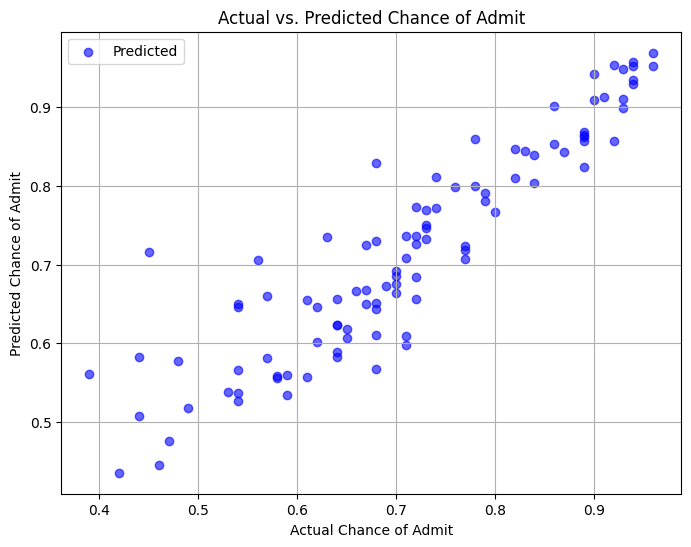

In [ ]:
y_pred = linear_regression(X_test_tensor).numpy()
y_true = y_test_tensor.numpy()

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, color='blue', label='Predicted', alpha=0.6)
#plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Actual')
plt.plot()
plt.xlabel("Actual Chance of Admit")
plt.ylabel("Predicted Chance of Admit")
plt.title("Actual vs. Predicted Chance of Admit")
plt.legend()
plt.grid()
plt.show()

#### Implementation using sklearn

Mean Squared Error (MSE): 0.0035088909219092557
R-squared (R2): 0.8284160918381782


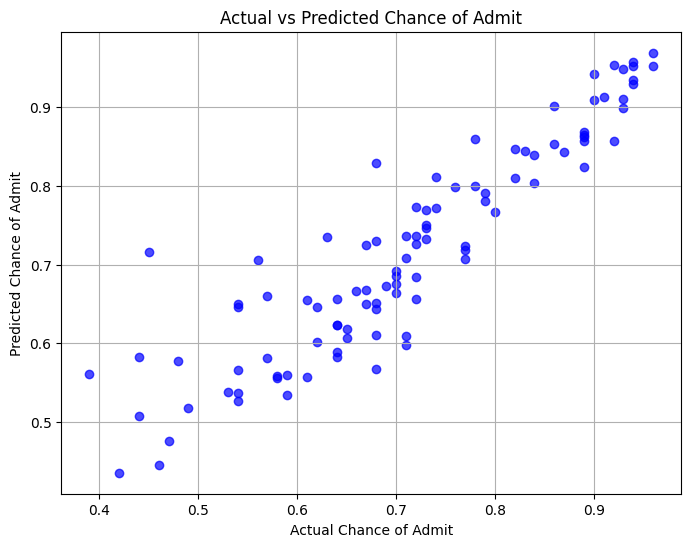

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
df_copy=pd.read_csv('Admission_Predict_A3.csv')
y_original=df_copy['Chance of Admit ']
X_train, X_test, y_train, y_test = train_test_split(X, y_original, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.xlabel("Actual Chance of Admit")
plt.ylabel("Predicted Chance of Admit")
plt.title("Actual vs Predicted Chance of Admit")
plt.plot()
plt.grid()
#plt.plot([y_test.min(),y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

We can see that both the models are giving almost similar scores.

The MSE of both the models is as follows:


*   SkLearn: 0.0035
*   Tensorflow: 0.0036



### Logistic Regression Using Tensorflow

#### Logistic Regression

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(df['Chance of Admit '])

y_categorical = to_categorical(y_encoded)

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(X_train_tf.shape[1],)),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_tf, y_train_tf, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

test_loss, test_accuracy = model.evaluate(X_test_tf, y_test_tf, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_probs = model.predict(X_test_tf)
y_pred_classes = tf.argmax(y_pred_probs, axis=1).numpy()
y_test_classes = tf.argmax(y_test_tf, axis=1).numpy()

y_pred_labels = le.inverse_transform(y_pred_classes)
y_test_labels = le.inverse_transform(y_test_classes)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.7830 - loss: 0.6847 - val_accuracy: 0.7875 - val_loss: 0.6593
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7727 - loss: 0.7029 - val_accuracy: 0.8000 - val_loss: 0.6484
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8348 - loss: 0.6248 - val_accuracy: 0.8000 - val_loss: 0.6383
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7638 - loss: 0.7162 - val_accuracy: 0.8125 - val_loss: 0.6289
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7749 - loss: 0.6666 - val_accuracy: 0.8250 - val_loss: 0.6201
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8209 - loss: 0.6396 - val_accuracy: 0.8250 - val_loss: 0.6118
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7702 - loss: 0.6820 - val_accuracy: 0.8250 - val_loss: 0.6040
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8143 - loss: 0.6193 - val_accuracy: 0.8

Learning Rate: 0.001, Test Accuracy: 0.7500
Learning Rate: 0.045, Test Accuracy: 0.8500
Learning Rate: 0.090, Test Accuracy: 0.8600
Learning Rate: 0.134, Test Accuracy: 0.8600
Learning Rate: 0.178, Test Accuracy: 0.8600
Learning Rate: 0.223, Test Accuracy: 0.8600
Learning Rate: 0.267, Test Accuracy: 0.8600
Learning Rate: 0.311, Test Accuracy: 0.8600
Learning Rate: 0.356, Test Accuracy: 0.8600
Learning Rate: 0.400, Test Accuracy: 0.8600


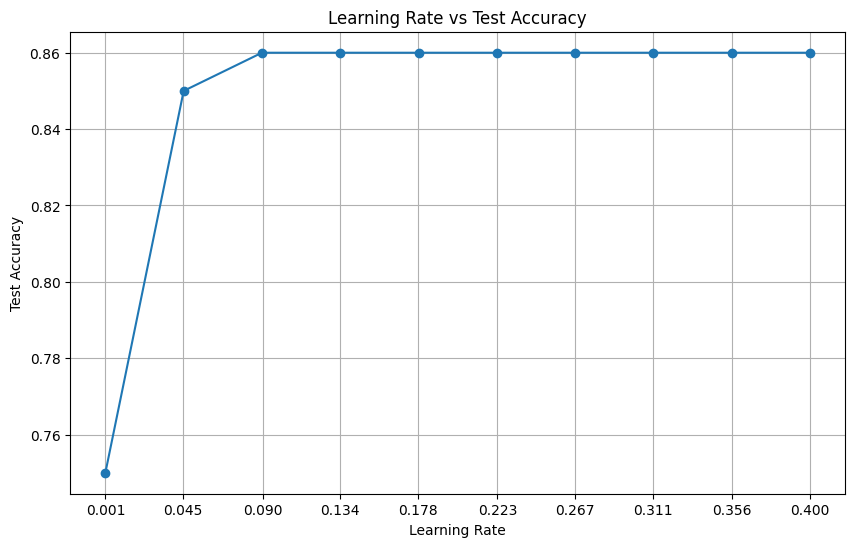

Best Learning Rate: 0.090, Best Test Accuracy: 0.8600


In [ ]:
def train_model_with_lr(learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(X_train_tf.shape[1],)),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train_tf, y_train_tf, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    return model

learning_rates = np.linspace(0.001, 0.4, 10)
accuracies = []

for lr in learning_rates:
    model = train_model_with_lr(lr)
    test_loss, test_accuracy = model.evaluate(X_test_tf, y_test_tf, verbose=0)
    accuracies.append(test_accuracy)
    print(f"Learning Rate: {lr:.3f}, Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, accuracies, marker='o')
plt.title('Learning Rate vs Test Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.xticks(np.round(learning_rates, 3))
plt.grid()
plt.show()

max_accuracy_index = np.argmax(accuracies)
best_learning_rate = learning_rates[max_accuracy_index]
best_accuracy = accuracies[max_accuracy_index]

print(f"Best Learning Rate: {best_learning_rate:.3f}, Best Test Accuracy: {best_accuracy:.4f}")

In [ ]:
log_reg_accuracy = accuracy_score(y_test_labels, y_pred_labels)
log_reg_precision = precision_score(y_test_labels, y_pred_labels, average='weighted',zero_division=1)
log_reg_recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
log_reg_f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

log_reg_auc_roc = roc_auc_score(y_test_tf, y_pred_probs, multi_class='ovr')

print(f"Logistic Regression Metrics:\n"
      f"Accuracy: {log_reg_accuracy:.4f}\n"
      f"Precision: {log_reg_precision:.4f}\n"
      f"Recall: {log_reg_recall:.4f}\n"
      f"F1 Score: {log_reg_f1:.4f}\n"
      f"AUC-ROC: {log_reg_auc_roc:.4f}\n")

Logistic Regression Metrics:
Accuracy: 0.8200
Precision: 0.8364
Recall: 0.8200
F1 Score: 0.7815
AUC-ROC: 0.8940



#### Comparision with random forest classifier

In [ ]:
df2=df
df2 = df2.rename(columns={'Chance of Admit ': 'admch'})

print(df2.head())

       LDA1      LDA2   admch
0 -3.088197  0.663746    High
1 -1.186912 -0.240582    High
2  0.867028 -0.926579  Medium
3 -0.332192 -1.136026    High
4  1.277001  1.267692  Medium


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df2.drop('admch', axis=1)
y = df2['admch']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=106)

rf_model = RandomForestClassifier()

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8000
Precision: 0.7967
Recall: 0.8000
F1 Score: 0.7894


In this case, Logistic Regression performs better than Random Forest Classifier

### Hyperparameter Tuning

#### Assessing effect of different learning rates for Linear Regression (Implementation using Tensorflow)

In [ ]:
def linear_regression(X, W, b):
    return tf.matmul(X, W) + b

def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def train_linear_regression(X_train_tensor, y_train_tensor, learning_rate=0.01, epochs=1000):
  num_features = X_train_tensor.shape[1]
  W = tf.Variable(tf.random.normal([num_features, 1], dtype=tf.float32), name="weights")
  b = tf.Variable(tf.random.normal([1], dtype=tf.float32), name="bias")

  optimizer = tf.optimizers.SGD(learning_rate)

  # Store loss for each epoch
  loss_history = []

  for epoch in range(epochs):
      with tf.GradientTape() as tape:
          y_pred = linear_regression(X_train_tensor, W, b)

          loss = mean_squared_error(y_train_tensor, y_pred)

      gradients = tape.gradient(loss, [W, b])

      optimizer.apply_gradients(zip(gradients, [W, b]))

      loss_history.append(loss.numpy())
      #converting loss back to a tf variable
      loss = tf.convert_to_tensor(loss)

      # if (epoch + 1) % 100 == 0:
      #     print(f"Epoch {epoch + 1}: Loss = {loss.numpy():.4f}")
  return W, b, loss_history



def plot_lr_results(y_true, y_pred):
  plt.figure(figsize=(8, 6))
  # Convert y_true and y_pred to NumPy arrays before plotting
  plt.scatter(y_true.numpy(), y_pred.numpy(), color='blue', label='Predicted', alpha=0.6)
  # Convert y_true to NumPy array before getting min and max for the line
  plt.plot([y_true.numpy().min(), y_true.numpy().max()], [y_true.numpy().min(), y_true.numpy().max()], 'r--', label='Actual')
  plt.xlabel("Actual Chance of Admit")
  plt.ylabel("Predicted Chance of Admit")
  plt.title("Actual vs. Predicted Chance of Admit")
  plt.legend()
  plt.grid()
  plt.show()


Learning Rate: 0.001, Epochs: 1000
R-squared (Accuracy): 0.6267213821411133
MSE (Loss): 0.007633544970303774


Learning Rate: 0.01, Epochs: 1000
R-squared (Accuracy): 0.8284151554107666
MSE (Loss): 0.003508909372612834


Learning Rate: 0.1, Epochs: 1000
R-squared (Accuracy): 0.8284161686897278
MSE (Loss): 0.0035088893491774797


Learning Rate: 0.2, Epochs: 1000
R-squared (Accuracy): 0.828416109085083
MSE (Loss): 0.0035088900476694107




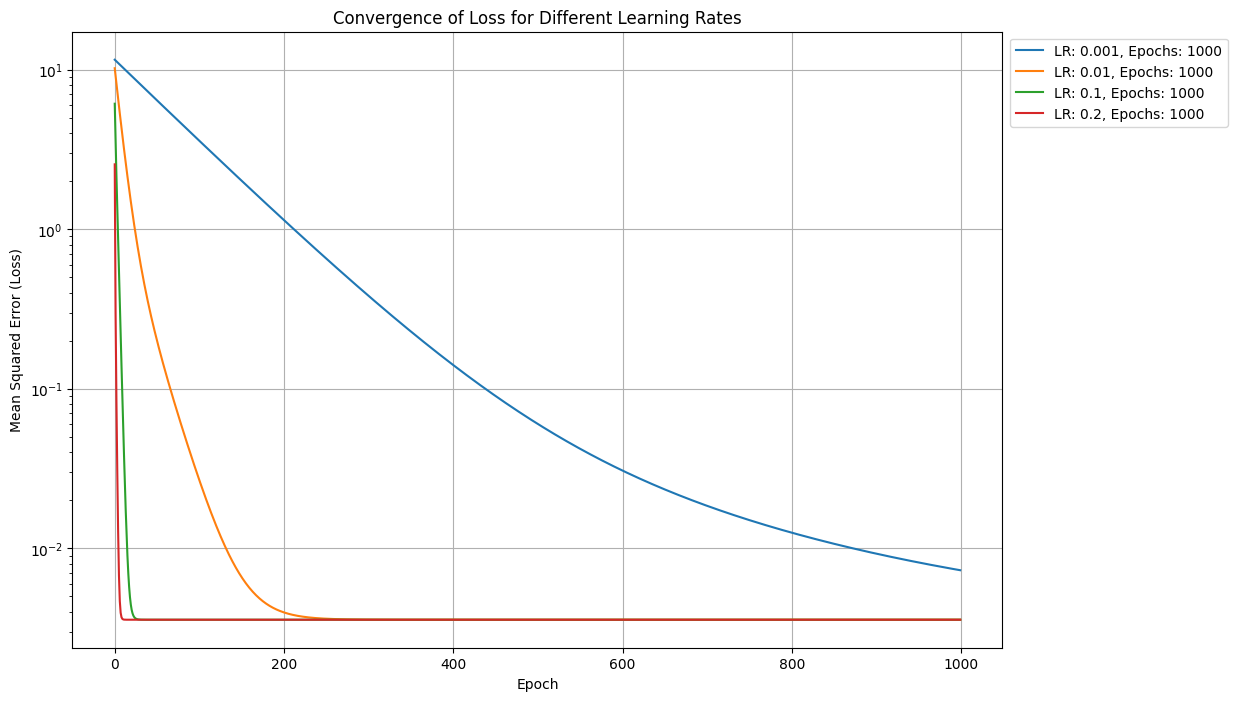

In [ ]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_original, test_size=0.2, random_state=42)
X_train_tensor = tf.constant(X_train, dtype=tf.float32)
y_train_tensor = tf.constant(y_train.values.reshape(-1, 1), dtype=tf.float32)
X_test_tensor = tf.constant(X_test, dtype=tf.float32)
y_test_tensor = tf.constant(y_test.values.reshape(-1, 1), dtype=tf.float32)
def hyperparameter_tuning(learning_rate, epochs):
  W, b, loss_history = train_linear_regression(X_train_tensor, y_train_tensor, learning_rate, epochs)
  y_pred = linear_regression(X_test_tensor, W, b)
  # plot_lr_results(y_test_tensor, y_pred)

  print(f"R-squared (Accuracy): {r2_score(y_test_tensor.numpy(),y_pred.numpy())}")
  print(f"MSE (Loss): {mean_squared_error(y_test_tensor,y_pred)}")

  return loss_history


loss_histories={}
learning_rates = [0.001, 0.01, .1, .2]
epochs=1000
for learning_rate in learning_rates:
    print(f"Learning Rate: {learning_rate}, Epochs: {epochs}")
    loss_history = hyperparameter_tuning(learning_rate, epochs)
    loss_histories[(learning_rate, epochs)] = loss_history
    print("\n")

# print(loss_histories)


plt.figure(figsize=(12, 8))
for learning_rate in learning_rates:
      label = f'LR: {learning_rate}, Epochs: {epochs}'
      plt.plot(loss_histories[(learning_rate, epochs)], label=label)

plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.yscale('log')  # Use log scale for better visibility of changes
plt.title('Convergence of Loss for Different Learning Rates')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.show()

From this we can see that a learning rate of 0.001 proves to be too slow and fails to converge within 1000 epochs. It's accuracy value is negative which happens if the model is performing worse than a simple baseline model.

For the learning rates .01, .1 and .2 we can see that they converge quickly, out of which .2 converges fastest.

But if we take too big a value, it will diverge instead of converging as it overshoots.

#### Using GridSearch to find best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor, LogisticRegression


# Perform GridSearchCV for Linear Regression
X_train, X_test, y_train, y_test = train_test_split(X, y_original, test_size=0.2, random_state=42)
linear_model = SGDRegressor()
linear_hyperparameters = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [500, 1000, 5000, 10000]}
linear_grid_search = GridSearchCV(estimator=linear_model, param_grid=linear_hyperparameters, cv=5)
linear_grid_search.fit(X_train, y_train)
print("Best parameters for Linear Regression:", linear_grid_search.best_params_)

# Perform GridSearchCV for Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logistic_model = LogisticRegression()
logistic_hyperparameters = {'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [500, 1000, 5000, 10000]}
logistic_grid_search = GridSearchCV(estimator=logistic_model, param_grid=logistic_hyperparameters, cv=5)
logistic_grid_search.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", logistic_grid_search.best_params_)



Best parameters for Linear Regression: {'alpha': 0.01, 'max_iter': 5000}
Best parameters for Logistic Regression: {'C': 10, 'max_iter': 500}


#### K-fold cross validation to test generalisation of Linear Regression model (Implementation using Tensorflow)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
kf.get_n_splits(X)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

    X_train_tensor = tf.constant(X_train, dtype=tf.float32)
    y_train_tensor = tf.constant(y_train.values.reshape(-1, 1), dtype=tf.float32)
    X_test_tensor = tf.constant(X_test, dtype=tf.float32)
    y_test_tensor = tf.constant(y_test.values.reshape(-1, 1), dtype=tf.float32)

    learning_rate = 0.01
    epochs = 1000

    W, b, loss_history = train_linear_regression(X_train_tensor, y_train_tensor, learning_rate, epochs)
    y_pred = linear_regression(X_test_tensor, W, b)

    print(f"R-squared (Accuracy): {r2_score(y_test_tensor.numpy(),y_pred.numpy())}")
    print(f"MSE (Loss): {mean_squared_error(y_test_tensor,y_pred)}")
    print('\n')


Fold 0
R-squared (Accuracy): 0.6942030191421509
MSE (Loss): 0.009301961399614811


Fold 1
R-squared (Accuracy): 0.7955365180969238
MSE (Loss): 0.0030708368867635727


Fold 2
R-squared (Accuracy): 0.8736047148704529
MSE (Loss): 0.0015804466092959046


Fold 3
R-squared (Accuracy): 0.8229503631591797
MSE (Loss): 0.0033699246123433113


Fold 4
R-squared (Accuracy): 0.9005173444747925
MSE (Loss): 0.0018027566839009523




#### K-fold cross validation using Linear Regression (Scikit-Learn Implementation)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

kf = KFold(n_splits=5)
kf.get_n_splits(X)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.predict(X_test)

    print(f"R-squared (Accuracy): {r2_score(y_test_tensor.numpy(),y_pred)}")
    print(f"MSE (Loss): {mean_squared_error(y_test_tensor,y_pred)}")
    print('\n')

Fold 0
R-squared (Accuracy): -0.4794630435435223
MSE (Loss): 0.026809809386426228


Fold 1
R-squared (Accuracy): -0.956778408462502
MSE (Loss): 0.03545938938542393


Fold 2
R-squared (Accuracy): -0.739591066225058
MSE (Loss): 0.03152367009054781


Fold 3
R-squared (Accuracy): -1.2457124704114197
MSE (Loss): 0.04069525327530046


Fold 4
R-squared (Accuracy): 0.9005170292055399
MSE (Loss): 0.0018027618167512699




#### K-fold cross validation for Logistic Regression (Using Scikit-Learn Implementation)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

kf = KFold(n_splits=5)
kf.get_n_splits(X)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lr_model = LogisticRegression()
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.predict(X_test)

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test), multi_class='ovr')

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"ROC AUC: {roc_auc}")
    print("\n")


Fold 0
Precision: 0.7062664165103189
Recall: 0.7
F1 Score: 0.6740343698854337
Accuracy: 0.7
ROC AUC: 0.8940748443149141


Fold 1
Precision: 0.8461705685618728
Recall: 0.84
F1 Score: 0.84
Accuracy: 0.84
ROC AUC: 0.9603610543375036


Fold 2
Precision: 0.9204545454545453
Recall: 0.92
F1 Score: 0.9198518518518519
Accuracy: 0.92
ROC AUC: 0.9738785338436838


Fold 3
Precision: 0.8376666666666667
Recall: 0.84
F1 Score: 0.8242348336594912
Accuracy: 0.84
ROC AUC: 0.951426059396565


Fold 4
Precision: 0.8897435897435898
Recall: 0.86
F1 Score: 0.870097902097902
Accuracy: 0.86
ROC AUC: 0.9765147582875432




Areas of Improvement:

1.   The tensorflow implementation of Linear Regression model and Logistic Regression shows variability in the accuracy values, ranging from .7 to .9. The Scikit-Learn implementation shows huge amounts of variability in performance across the folds. This might be happening due to the presence of unbalanced data in the fold. One thing we can do that would potentially improve this would be to use Stratified-K-fold Cross Validation.
2.   Regularisation may further help in reducing overfitting and result in better generalisation.






Potential Bias:


1.   Linear regression is inherently biased towards linear relationships. If the true relationship between the features and target is non-linear, the model will not capture it well, resulting in poor generalization.
2.   For Logistic regression,  if one class is significantly more common than others, the model might be biased towards predicting that class. This can result in high accuracy but poor recall for the minority class.
3. Further, differences in the data distribution across folds could lead to varying performance. The model might be performing better on folds where the class distribution is more similar to the training data.



### Additional Tasks

#### Linear Regression without using lda

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
df2=pd.read_csv('/content/Admission_Predict_A3.csv')
df2 = df2.rename(columns={'Chance of Admit ': 'admch'})

X = df2.drop('admch', axis=1)
y = df2['admch']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=106)

X.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,1,337,118,4,4.5,4.5,9.65,1
1,2,324,107,4,4.0,4.5,8.87,1
2,3,316,104,3,3.0,3.5,8.00,1
3,4,322,110,3,3.5,2.5,8.67,1
4,5,314,103,2,2.0,3.0,8.21,0


Mean Squared Error (MSE): 0.0033644508243873567
R-squared (R2): 0.8203710184523568


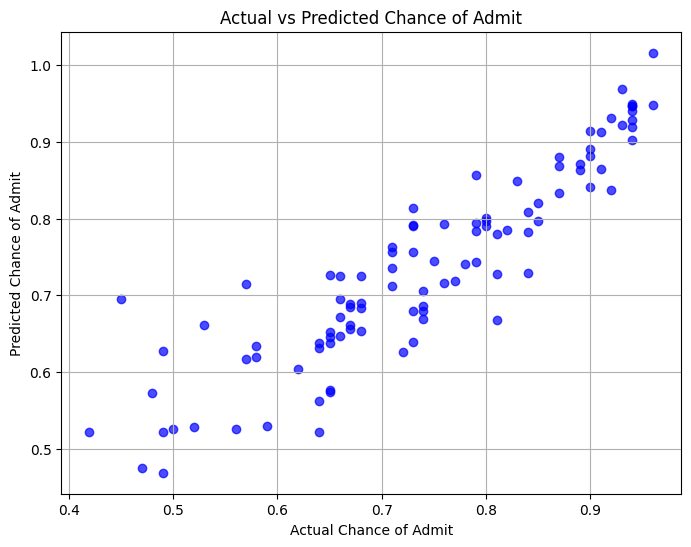

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.xlabel("Actual Chance of Admit")
plt.ylabel("Predicted Chance of Admit")
plt.title("Actual vs Predicted Chance of Admit")
plt.plot()
plt.grid()
plt.show()

This model has almost similar precision but slightly lower R2-score than the model with lda transformed features.

#### Comparing convergence speed of different gradient descent algorithms

##### SGD

In [ ]:
import tensorflow as tf
import numpy as np
import time

X = df_lda.drop('Chance of Admit ', axis=1)
y = df_lda['Chance of Admit ']
X_train, X_test, y_train, y_test = train_test_split(X, y_original, test_size=0.2, random_state=106)

X_train_tensor = tf.constant(X_train, dtype=tf.float32)
y_train_tensor = tf.constant(y_train.values.reshape(-1, 1), dtype=tf.float32)
X_test_tensor = tf.constant(X_test, dtype=tf.float32)
y_test_tensor = tf.constant(y_test.values.reshape(-1, 1), dtype=tf.float32)

num_features = X_train_tensor.shape[1]
W = tf.Variable(tf.random.normal([num_features, 1], dtype=tf.float32), name="weights")
b = tf.Variable(tf.random.normal([1], dtype=tf.float32), name="bias")

def linear_regression(X):
    return tf.matmul(X, W) + b

def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

optimizer = tf.optimizers.SGD(learning_rate=0.01)

epochs = 100
loss_history = []
start_time = time.time()

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        y_pred = linear_regression(X_train_tensor)
        loss = mean_squared_error(y_train_tensor, y_pred)

    gradients = tape.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))

    loss_history.append(loss.numpy())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}: Loss = {loss.numpy():.4f}")

end_time = time.time()
training_time = end_time - start_time

print(f"Total training time: {training_time:.2f} seconds")

loss_decreases = np.diff(loss_history)
average_loss_decrease = np.mean(loss_decreases[loss_decreases < 0])

print(f"Average loss decrease per epoch: {average_loss_decrease:.4f}")

Epoch 10: Loss = 0.2696
Epoch 20: Loss = 0.1615
Epoch 30: Loss = 0.1035
Epoch 40: Loss = 0.0687
Epoch 50: Loss = 0.0467
Epoch 60: Loss = 0.0323
Epoch 70: Loss = 0.0227
Epoch 80: Loss = 0.0164
Epoch 90: Loss = 0.0121
Epoch 100: Loss = 0.0093
Total training time: 0.57 seconds
Average loss decrease per epoch: -0.0047


##### Batch Gradient Descent

In [ ]:
import tensorflow as tf
import numpy as np
import time

num_samples=df_lda.shape[0]

X = df_lda.drop('Chance of Admit ', axis=1)
y = df_lda['Chance of Admit ']
X_train, X_test, y_train, y_test = train_test_split(X, y_original, test_size=0.2, random_state=106)

X_train_tensor = tf.constant(X_train, dtype=tf.float32)
y_train_tensor = tf.constant(y_train.values.reshape(-1, 1), dtype=tf.float32)
X_test_tensor = tf.constant(X_test, dtype=tf.float32)
y_test_tensor = tf.constant(y_test.values.reshape(-1, 1), dtype=tf.float32)

num_features = X_train_tensor.shape[1]
W = tf.Variable(tf.random.normal([num_features, 1], dtype=tf.float32), name="weights")
b = tf.Variable(tf.random.normal([1], dtype=tf.float32), name="bias")

def linear_regression(X):
    return tf.matmul(X, W) + b

def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

optimizer = tf.optimizers.SGD(learning_rate=0.01)

epochs = 100
loss_history = []
start_time = time.time()

for epoch in range(epochs):
  for n in range(num_samples):
    with tf.GradientTape() as tape:
        y_pred = linear_regression(X_train_tensor)
        loss = mean_squared_error(y_train_tensor, y_pred)

    gradients = tape.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))

    loss_history.append(loss.numpy())

end_time = time.time()
training_time = end_time - start_time

print(f"Total training time: {training_time:.2f} seconds")

loss_decreases = np.diff(loss_history)
average_loss_decrease = np.mean(loss_decreases[loss_decreases < 0])

print(f"Average loss decrease per epoch: {average_loss_decrease:.4f}")

Total training time: 278.12 seconds
Average loss decrease per epoch: -0.0177


##### Mini Batch Gradient Decent

In [ ]:
import tensorflow as tf
import numpy as np
import time

X = df_lda.drop('Chance of Admit ', axis=1)
y = df_lda['Chance of Admit ']
X_train, X_test, y_train, y_test = train_test_split(X, y_original, test_size=0.2, random_state=106)

X_train_tensor = tf.constant(X_train, dtype=tf.float32)
y_train_tensor = tf.constant(y_train.values.reshape(-1, 1), dtype=tf.float32)
X_test_tensor = tf.constant(X_test, dtype=tf.float32)
y_test_tensor = tf.constant(y_test.values.reshape(-1, 1), dtype=tf.float32)

num_features = X_train_tensor.shape[1]
W = tf.Variable(tf.random.normal([num_features, 1], dtype=tf.float32), name="weights")
b = tf.Variable(tf.random.normal([1], dtype=tf.float32), name="bias")

def linear_regression(X):
    return tf.matmul(X, W) + b

def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

optimizer = tf.optimizers.SGD(learning_rate=0.01)

epochs = 100
loss_history = []
start_time = time.time()

for epoch in range(epochs):
  for n in range(32):
    with tf.GradientTape() as tape:
        y_pred = linear_regression(X_train_tensor)
        loss = mean_squared_error(y_train_tensor, y_pred)

    gradients = tape.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))

    loss_history.append(loss.numpy())

end_time = time.time()
training_time = end_time - start_time

print(f"Total training time: {training_time:.2f} seconds")

loss_decreases = np.diff(loss_history)
average_loss_decrease = np.mean(loss_decreases[loss_decreases < 0])

print(f"Average loss decrease per epoch: {average_loss_decrease:.4f}")

Total training time: 67.65 seconds
Average loss decrease per epoch: -0.0060
